In [ ]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive/My Drive/homework1/Lorenzo

Mounted at /gdrive
/gdrive/.shortcut-targets-by-id/1PvkX4sbcEWK_cdC6p2PgUCbyCESBGxq3/homework1/Lorenzo


### Import libraries

In [ ]:
# Fix randomness and hide warnings
seed = 42

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['MPLCONFIGDIR'] = os.getcwd()+'/configs/'

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

import numpy as np
np.random.seed(seed)

import logging

import random
random.seed(seed)

In [ ]:
# Import tensorflow
import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl
!pip install keras-tuner -q
import keras_tuner
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)
print(tf.__version__)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.9/128.9 kB 2.6 MB/s eta 0:00:00
2.14.0


In [ ]:
# Import other libraries
import math
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
import seaborn as sns

## Dataset

### Load the data

In [ ]:
dataset = np.load('../initial_dataset/public_data.npz', allow_pickle=True)
X = dataset['data']
y = dataset['labels']
labels = {0:'healthy', 1:'unhealthy'}

print(f'Dataset Data Shape {X.shape}, type = {X[0].dtype}')
print(f'Dataset Labels Shape {y.shape}')


Dataset Data Shape (5200, 96, 96, 3), type = float32
Dataset Labels Shape (5200,)


## Inspect the data

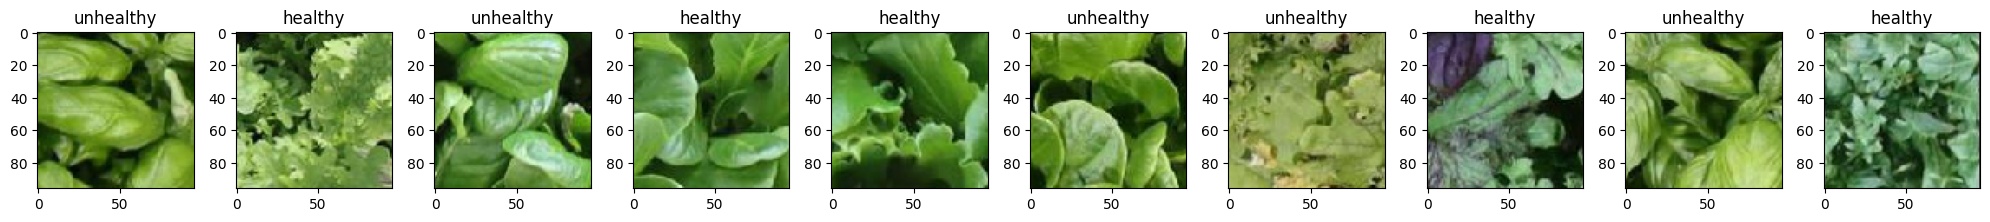

In [ ]:
# Display a sample of images from the training-validation dataset
def visualizeData(data):
  num_img = 10
  to_show = np.random.randint(0, data.shape[0], num_img);
  fig, axes = plt.subplots(1, num_img, figsize=(20, 20))

  # Iterate through the selected number of images
  for i in range(num_img):
      ax = axes[i]
      ax.imshow(data[to_show[i]]/255)
      ax.set_title('{}'.format(y[to_show[i]]))

  # Adjust layout and display the images
  plt.tight_layout()
  plt.show()

visualizeData(X)

In [ ]:
# Display the count of occurrences of target classes in the training-validation dataset
print('Counting occurrences of target classes:')
print(pd.DataFrame(y, columns=['class'])['class'].value_counts())

Counting occurrences of target classes:
healthy      3199
unhealthy    2001
Name: class, dtype: int64


### Inspection consideration
1. Labels are not balanced
2. Outliers on the dataset are present
3. Labels are not correctly formatted 'healthy' -> 0, 'unhealthy' -> 1
4. Dataset is not normalized

## Preprocessing

### Labels encoding

In [ ]:
def custom_label_encoder(data, encoding_preferences):
    encoded_data = np.array([encoding_preferences.get(val, -1) for val in data])
    return encoded_data


encoding = {
    'healthy': 0,
    'unhealthy': 1,
}
y_enc = custom_label_encoder(y, encoding)
y = tfk.utils.to_categorical(y_enc,len(np.unique(y_enc)), dtype='int')

print(f'Dataset Labels Shape {y.shape}')
# Display the count of occurrences of target classes in the training-validation dataset
print('Counting occurrences of target classes:')
print(pd.DataFrame(np.argmax(y, axis=-1), columns=['class'])['class'].value_counts())


Dataset Labels Shape (5200, 2)
Counting occurrences of target classes:
0    3199
1    2001
Name: class, dtype: int64


### Dataset normalized

In [ ]:
X = (X / 255).astype('float32')
print(f'Dataset Data Shape {X.shape}')


Dataset Data Shape (5200, 96, 96, 3)


## Embedding

In [ ]:
input_shape = X.shape[1:]

In [ ]:
baseline_model = tfk.applications.ConvNeXtBase(
    include_top=False,
    weights="imagenet",
    pooling='avg',
    input_shape=input_shape,
)

350926856/350926856 [==============================] - 4s 0us/step


### Train the model

In [ ]:
encoded_imgs = baseline_model.predict(X * 255)

163/163 [==============================] - 38s 140ms/step


# DBScan

In [ ]:
from sklearn.cluster import DBSCAN

clustering = DBSCAN(eps=0.5, min_samples=5).fit(encoded_imgs).labels_

### Outliers visualization

In [ ]:
cluster_classes, counts = np.unique(clustering, return_counts=True)
outlier_classes = [0, 1]
outliers_idxs = [i for i in range(clustering.shape[0]) if clustering[i] in outlier_classes]
print(cluster_classes, counts)

[-1  0  1] [5004   98   98]


20 10 196


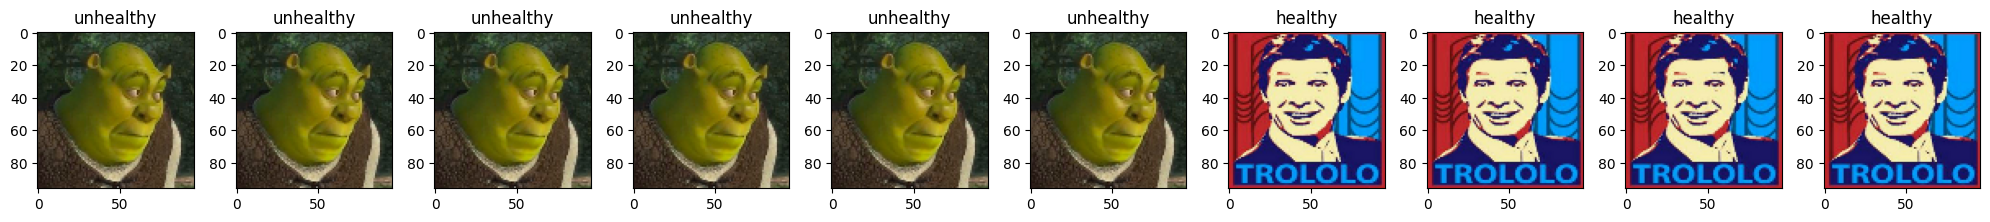

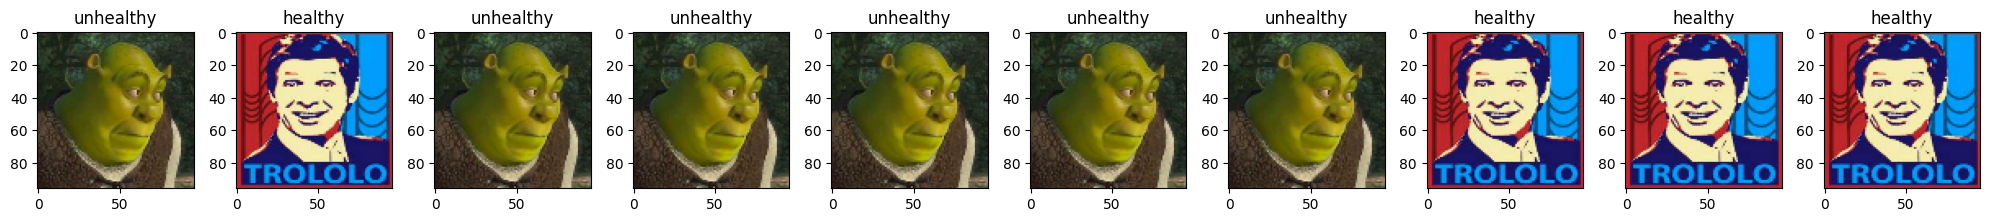

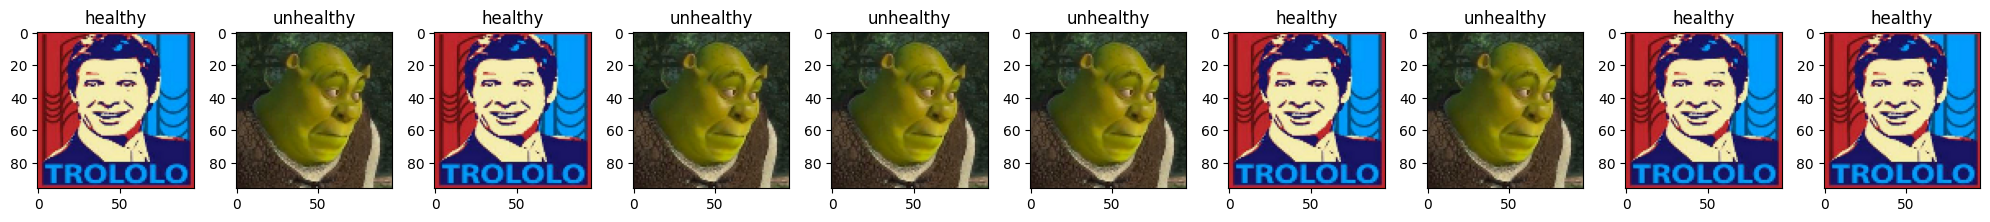

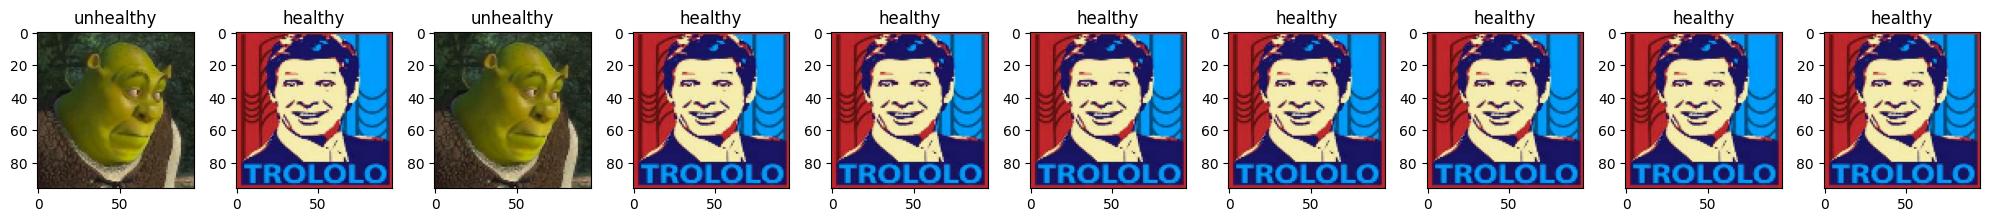

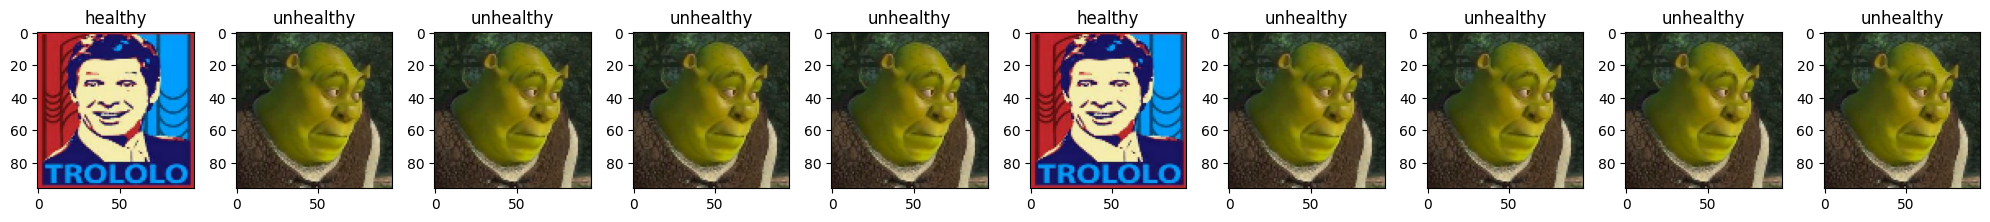

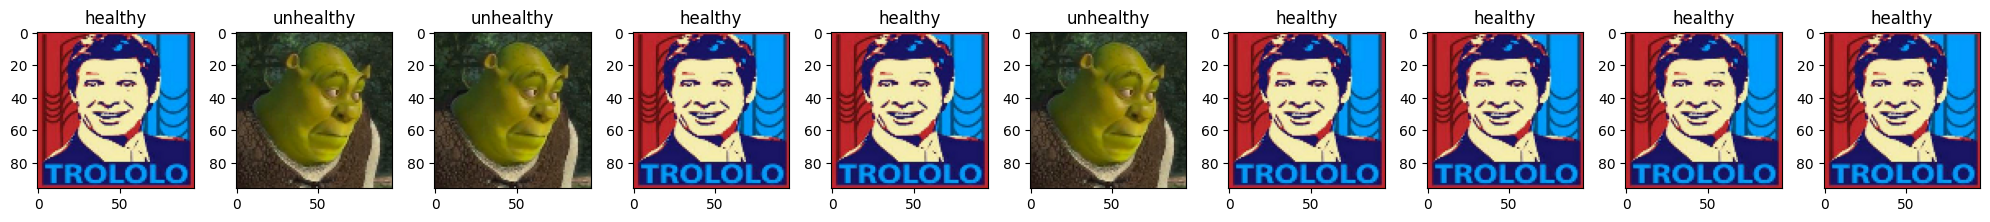

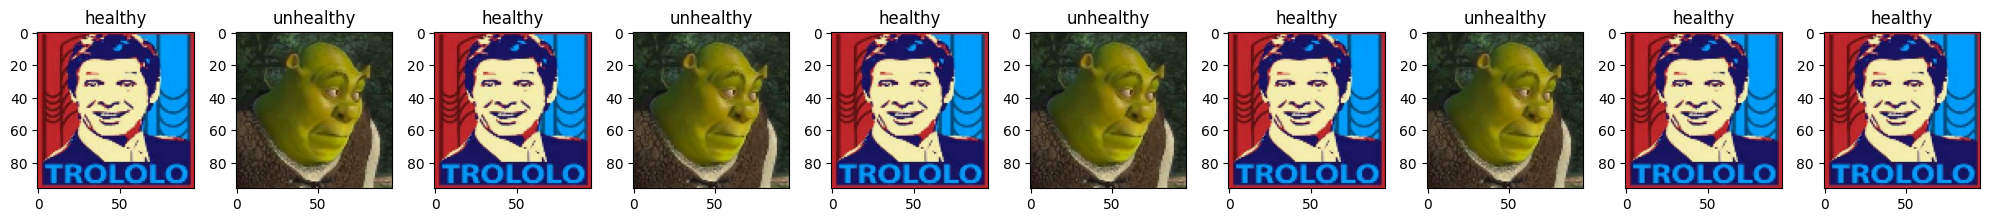

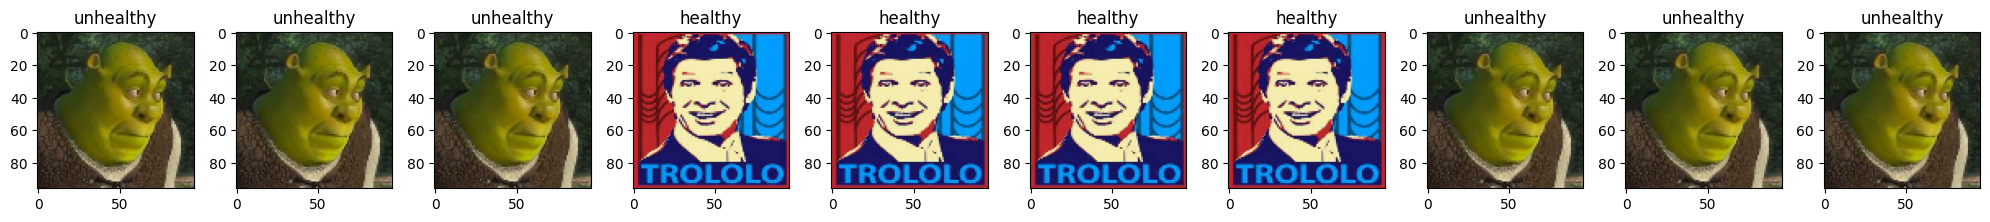

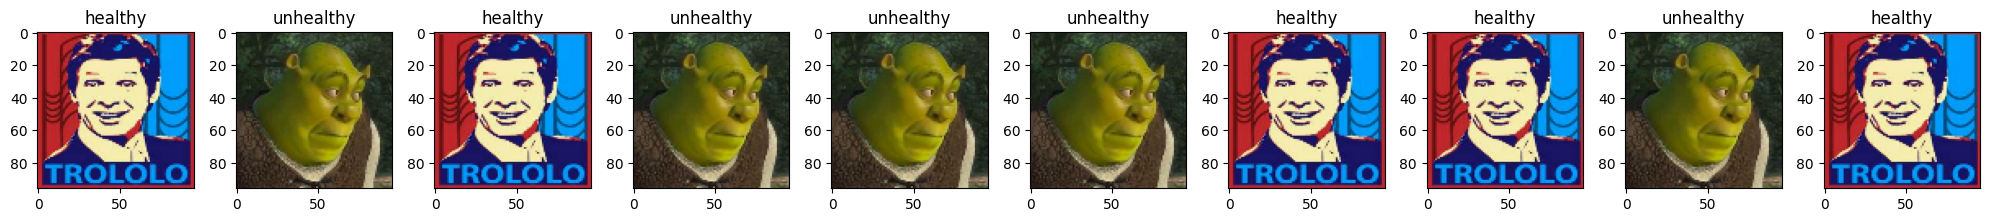

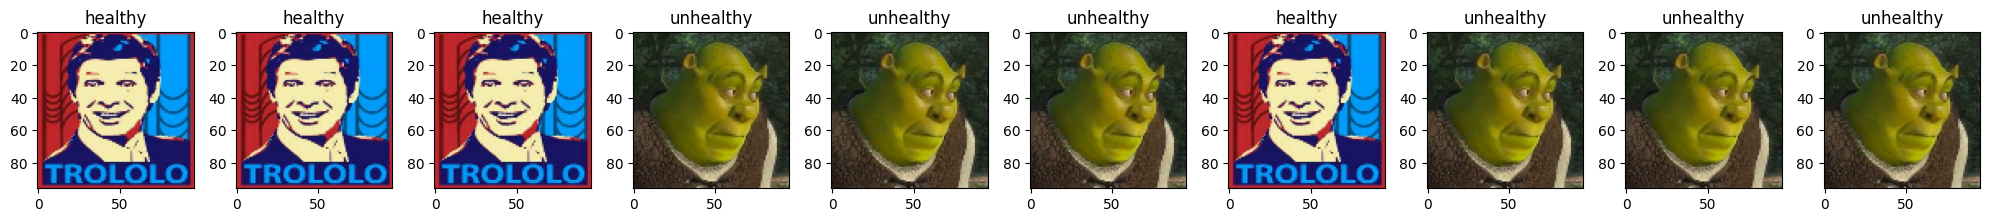

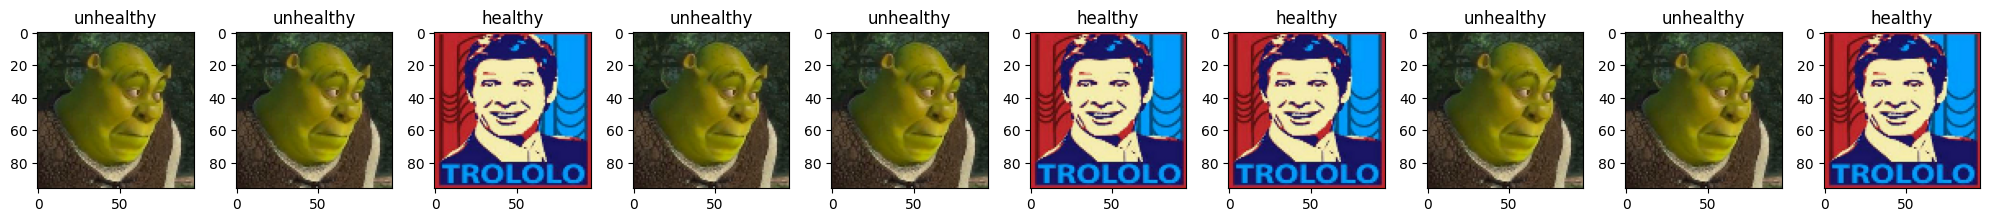

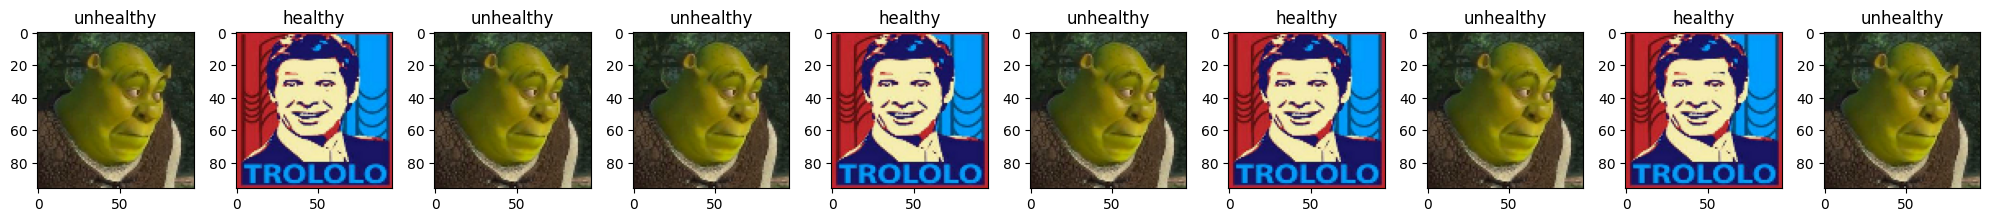

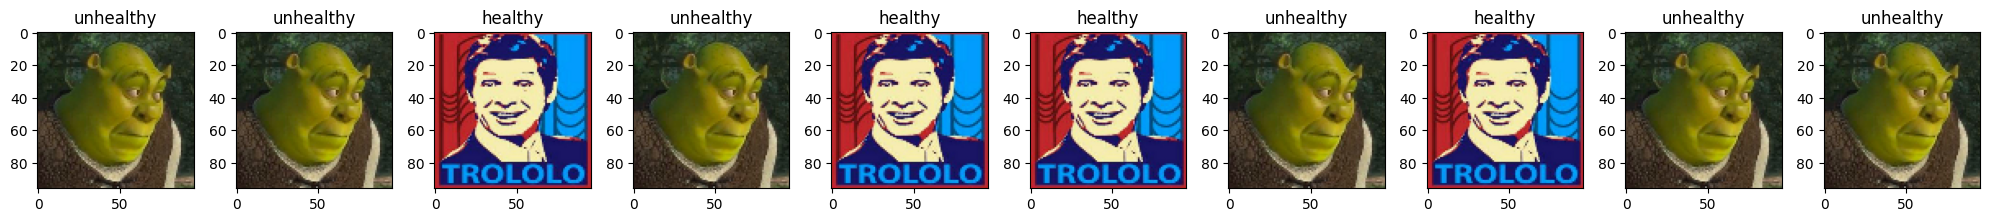

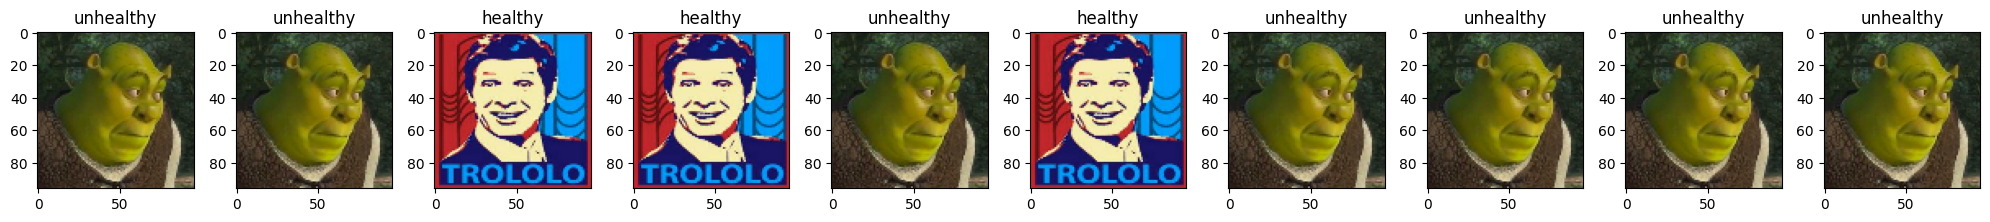

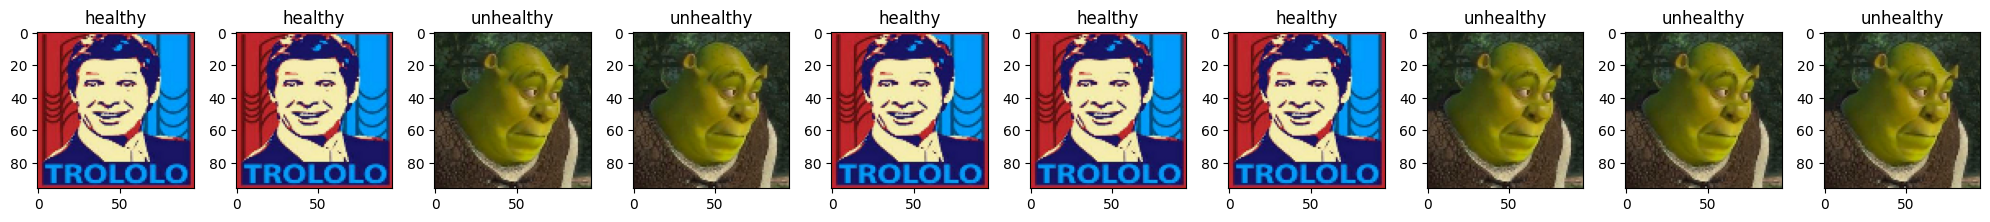

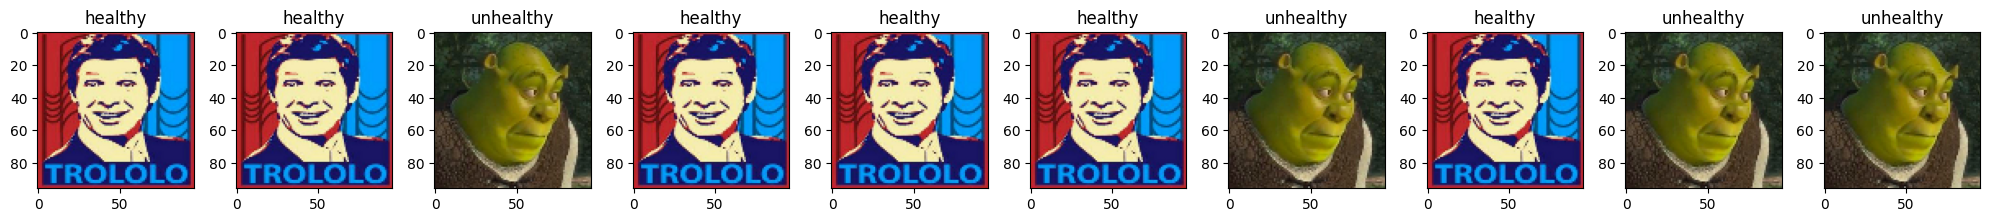

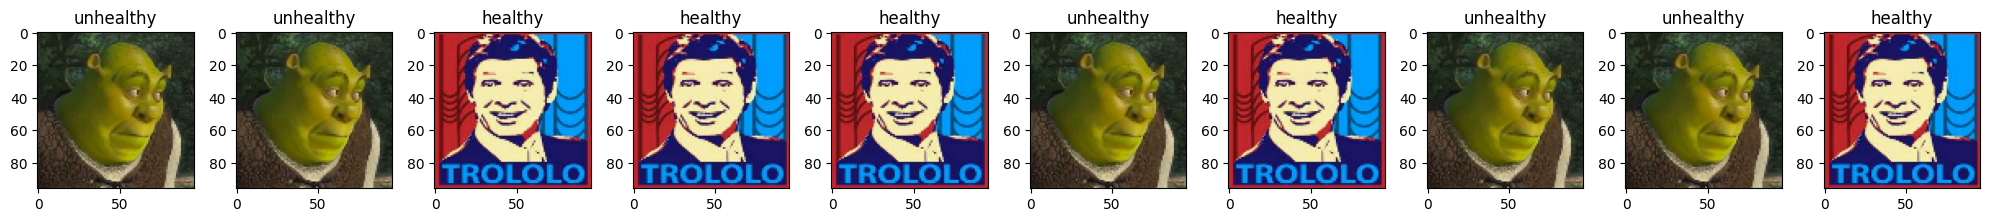

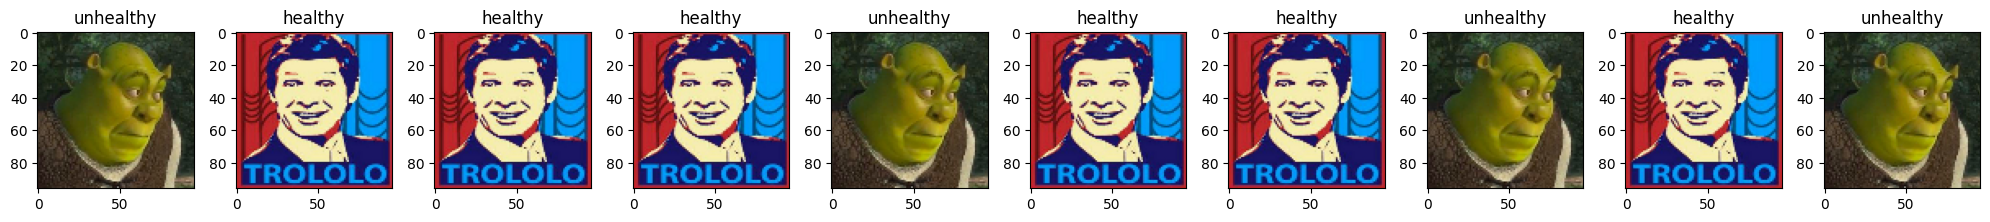

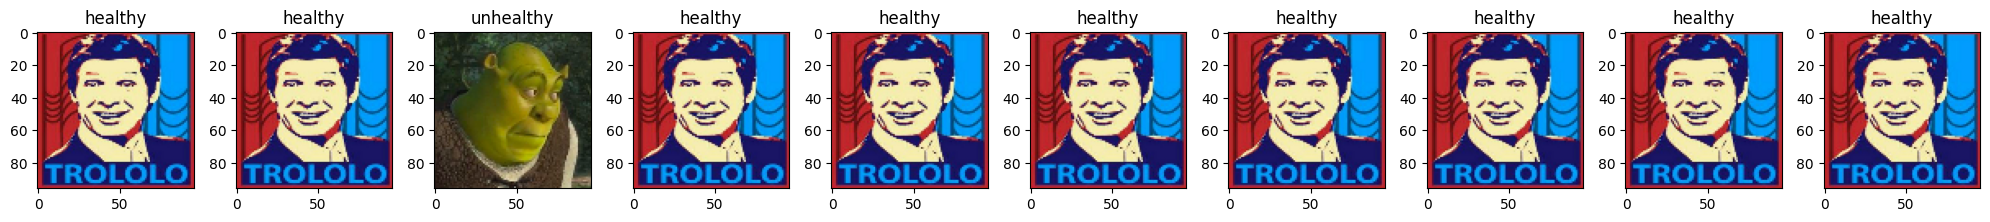

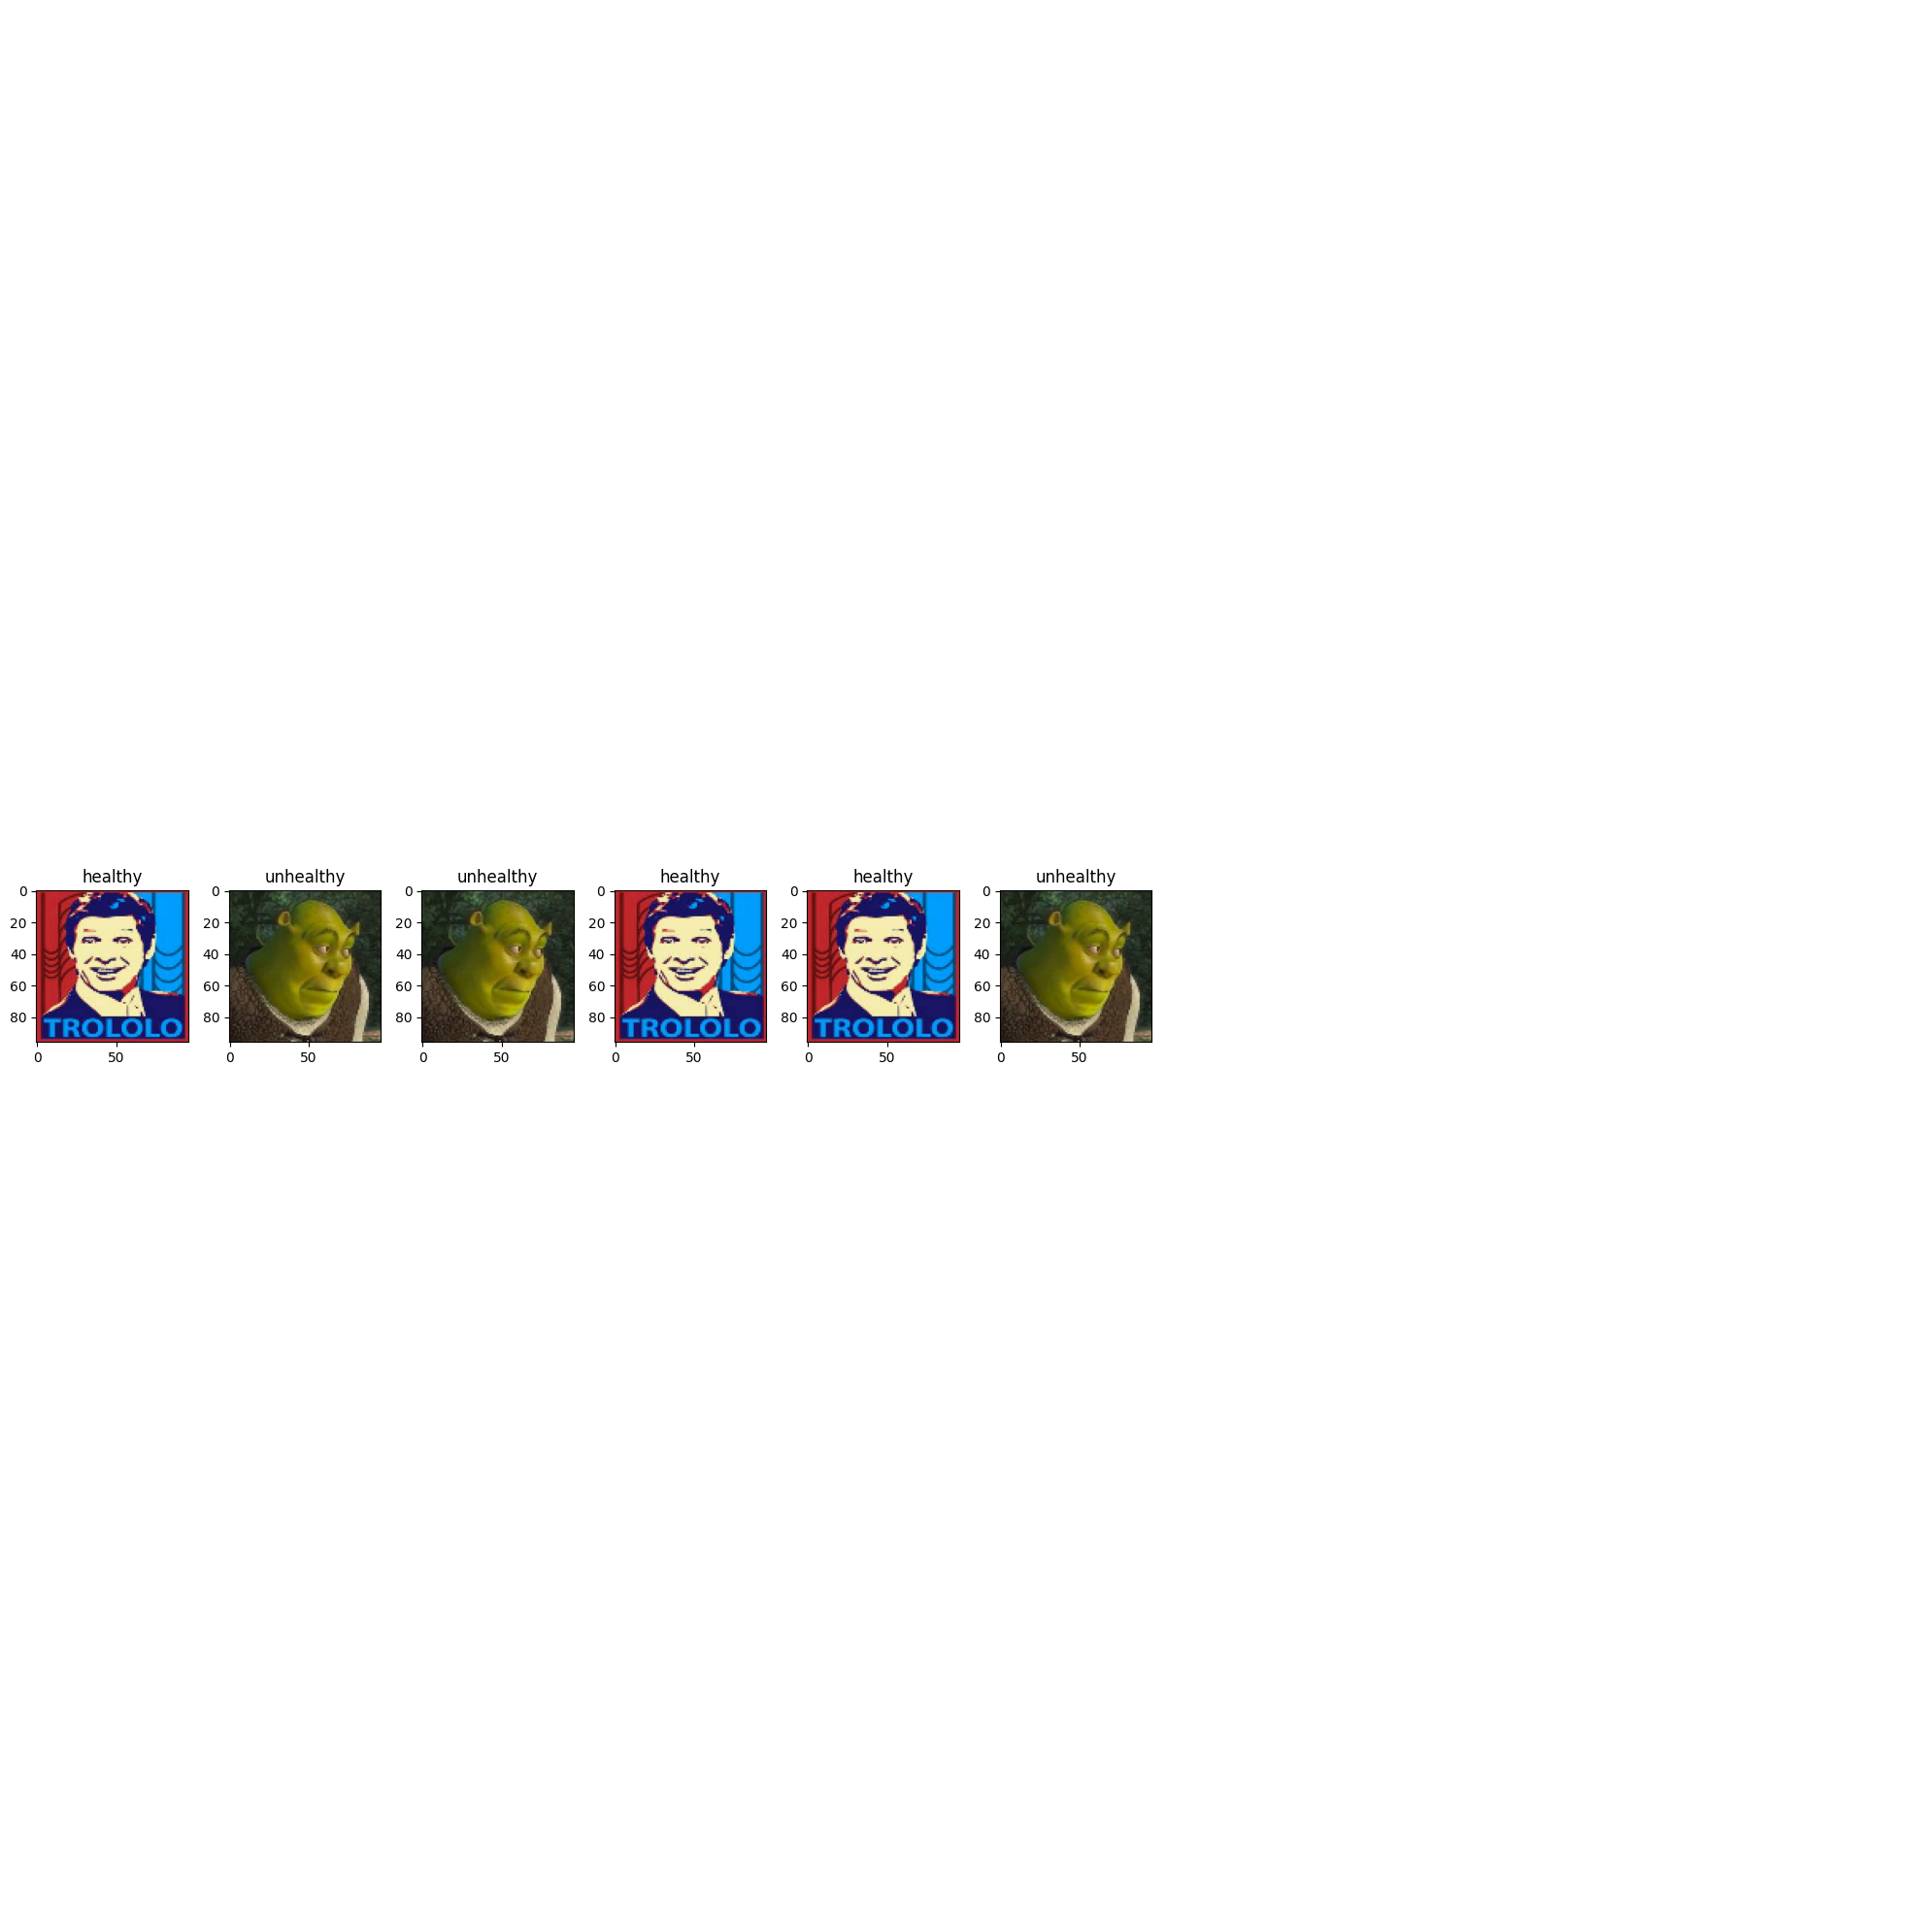

In [ ]:
# Display a sample of images from the training-validation dataset
to_display = 10
n_outliers = len(outliers_idxs)
rows = math.ceil(n_outliers/to_display)
print(rows, to_display, n_outliers)
count = []
for row in range(rows):
    # Iterate through the selected number of images
    fig, axes = plt.subplots(1, to_display, figsize=(20, 20))
    for col in range(to_display):
        outlier_idx = row*to_display + col
        ax = axes[col]
        if (outlier_idx < n_outliers):
            img_idx = outliers_idxs[outlier_idx];
            count.append(img_idx)
            ax.imshow(X[img_idx])
            ax.set_title('{}'.format(labels[y_enc[img_idx]]))
        else:
            ax.axis('off')  # Hide axes to create empty slots
            ax.set_title('')


    # Adjust layout and display the images
    plt.tight_layout()
    plt.show()